In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import path

import shapely
from shapely.geometry import Polygon
from shapely import speedups
#from shapely.errors import TopologicalError

import warnings
warnings.filterwarnings('ignore')

from scipy.optimize import differential_evolution, basinhopping, shgo, dual_annealing

import cv2

from sections import section, VERTEX_FUNCTIONS

In [2]:
if speedups.available:
    speedups.enable()

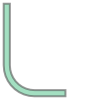

In [3]:
ll = section('l2', 30, 2, 20, 8)
ll

In [4]:
ll.is_valid

True

#### Affine Transformation

Allgemein: 
```
| a  b  xoff |
| d  e  yoff |
| 0  0  1    |
```

Spiegelung:
```
| 1   0  0 |
| 0  -1  0 |
| 0   0  1 |
```


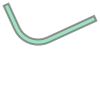

In [5]:
# matrix given as tuple/list: [a, b, d, e, xoff, yoff]

#shapely.affinity.affine_transform(ll)
#shapely.affinity.rotate(ll, 20, origin='center', use_radians=False)

mirror = -0.9 # wenn < 0: 
theta = 2 # rad
x0 = 10
y0 = 30

#mir = [1, 0, 0, -1, 0, 0]
sm = np.sign(mirror)

# 2. zeile mit +/- 1 multiplizieren
mat = [np.cos(theta), np.sin(theta), -np.sin(theta)*sm, np.cos(theta)*sm, x0, y0*sm]

l2 = shapely.affinity.affine_transform(ll, mat)
l2

## Optimize

- optimise shape parameters and orientation
- criterion is symmetric difference

#### Orientierung

was funktionieren könnte: Orientierung als parameter rausnehmen.

- Hauptträgheitsachsen von p0 berechnen
- dann hauptträgheitsachsen von py berechnen
- übereinanderlegen

#### TODO: 

- Parametersuche auch für nicht exakte Übereinstimmung (z.B. Profil mit kleinen Fasen)

In [6]:
def cost(x, p0, section_type):
    # first element of x: theta
    theta = x[0]
    # rest: shape parameters
    try:
        poly = section(section_type, *x[1:])
        poly = shapely.affinity.rotate(poly, theta, use_radians=True)
        poly = shapely.affinity.translate(poly, -poly.centroid.x, -poly.centroid.y)
        diff = p0.symmetric_difference(poly)
        return diff.area/p0.area
    except:
        return 2.0 # FIXME: this is an arbitrary value - anything better?


[(3.9668815826578685, 37.41390371212898)]
[(3.768251578806047, 38.036721248763946)]
[(-7.359223865500542e-15, -3.0469279473465744e-14)]


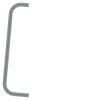

In [6]:
# h, tw, ba, ta, bf, tf
sectype = "c2"
#x0 = [30, 2.5, 20, 3, 8, 6] # for z1, c1
x0 = [80, 1.6, 22, 8, 15, 8]
p0 = section(sectype, *x0)
print(p0.centroid.coords[:])
p0 = shapely.affinity.rotate(p0, -5)
print(p0.centroid.coords[:])
# move centroid to origin
p0 = shapely.affinity.translate(p0, -p0.centroid.x, -p0.centroid.y)
print(p0.centroid.coords[:])

p0

In [7]:
bounds = [(-np.pi, np.pi)] + \
         [(10, 100), (0.6, 10), (5, 50), (2, 10), (5, 50), (2, 10)]
# [(0.1, 50), (0.1, 50)]
#xstart = [0] + [30, 3, 10, 3, 10, 3]


# works
result = differential_evolution(cost, bounds, atol=0.001, tol=0.001, maxiter=10000,
                                args=(p0, sectype), strategy='best1bin')

# does not work 
#result = basinhopping(cost, xstart, minimizer_kwargs={"args": (p0, sectype)})

# does not work at all...
#result = shgo(cost, bounds, args=(p0, sectype), options={"fmin": 0})

# funktioniert auch
# this accepts an initial start value !!!
#result = dual_annealing(cost, bounds, args=(p0, sectype), )

#result.x, result.fun

In [8]:
print(result.x)
print(result.fun)

[-0.08726646 79.99955214  1.60000004 22.00132127  7.99992134 14.99908696
  7.99429433]
0.00026534804398407023


In [9]:
result.nfev

11954

[(3.9668815682885157, 37.41390428749565)]
[(3.768273642118408, 38.03677856093389)]
[(1.2039547025899532e-14, 2.714827174090439e-14)]


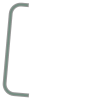

In [10]:
px = section(sectype, *result.x[1:])
print(px.centroid.coords[:])
px = shapely.affinity.rotate(px, result.x[0], use_radians=True)
print(px.centroid.coords[:])
px = shapely.affinity.translate(px, -px.centroid.x, -px.centroid.y)
print(px.centroid.coords[:])
px

In [11]:
p0.symmetric_difference(px).area / p0.area

0.00026534804398407023

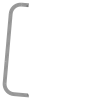

In [12]:
p0.symmetric_difference(px)

## Statistics: line directions and lengths


In [14]:
b = p0.boundary # LineString

In [15]:
from collections import defaultdict

coords = np.array(b.coords[:])
n_coords = len(coords)
lengths = defaultdict(float)

for i in range(n_coords-1):
    p0 = coords[i]
    p1 = coords[i+1]
    v = p1-p0
    length = np.linalg.norm(v)
    #alpha = np.arctan2(v[1], v[0]) 
    alpha = np.arctan(v[1]/v[0]) # 180% range is sufficient
    alpha = np.degrees(alpha)
    alpha = np.round(alpha, decimals=3)
    lengths[alpha] += length

In [16]:
for k in sorted(lengths.keys()):
    print(k, lengths[k])

-90.0 1.673390260755042
-80.0 3.067882144717565
-70.0 3.0678821447175695
-60.0 3.0678821447175633
-50.0 3.0678821447175664
-40.0 3.067882144717567
-30.0 3.067882144717578
-20.0 3.0678821447175664
-10.0 3.0678821447175633
-5.0 35.599999999999994
0.0 3.0678821447175633
10.0 3.067882144717568
20.0 3.067882144717568
30.0 3.0678821447175784
40.0 3.0678821447175357
50.0 3.0678821447175926
60.0 3.067882144717566
70.0 3.0678821447175917
80.0 3.0678821447175584
85.0 124.80000000000001
90.0 1.3944918839625338


In [17]:
# make an array out of it
k = np.array(list(lengths.keys()))
v = np.array(list(lengths.values()))


In [18]:
vi = np.argsort(v)[::-1] # descending
k[vi[:3]], v[vi[:3]] # angles with largest lengths

(array([85., -5., 50.]), array([124.8       ,  35.6       ,   3.06788214]))

In [19]:
np.quantile(v, .9, interpolation='nearest')

3.0678821447175926

In [20]:
# c section
params = {"h":50, "tw":2, "ba":23, "ta":2, "bf":15, "tf":3}

rules = """
h > 20,
h < 200,
tw > .8,
ta > .8,
tf > .8,
h >= ba,
h >= bf, 
h > 3*tw, 
h < 50*tw, 
ba < 30*ta, 
ba > 3*ta,
ba > tw, 
bf < 20*tf, 
bf > 0.5*tf, 
bf > tw,
h > 3*(tf+ta)
"""

In [21]:
rules = rules.strip().split(",")

In [22]:
#rls = [r.strip() for r in rules.split("\n")]

all([eval(r, {}, params) for r in rules])

True